### Naive vs Marla

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import sys
sys.path.append("../traffic_generator")
sys.path.append("../interference_injection")

In [ ]:
# Path to local CSV folder
csv_folder = "/home/george/Workshop/Interference/Results/traffic_generator_csvs"
naive_logs_folder = "/home/george/Workshop/Interference/Results/naive_logs"
marla_logs_folder = "/home/george/Workshop/Interference/Results/marla_logs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))


In [17]:
def plot_metric_over_time(csv_filenames, metric="P99_Latency", folder_path=csv_folder):
    """
    Plots the selected metric over time for selected CSV files, keeping only values below 20 for P99_Latency.
    
    Args:
        csv_filenames (list): List of CSV filenames (e.g., ["naive_v01.csv", "balanced_ramp.csv"]).
        metric (str): The metric column to plot (default: "P99_Latency").
        folder_path (str): Folder where the CSV files are stored.
    """
    plt.figure(figsize=(12, 6))

    for filename in csv_filenames:
        full_path = os.path.join(folder_path, filename)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
            continue
        
        df = pd.read_csv(full_path)
        df['Minute'] = pd.to_numeric(df['Minute'], errors='coerce')
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df = df[df[metric] < 20]  # Keep only values below 20 
        
        label = filename.replace(".csv", "")
        plt.plot(df['Minute'], df[metric], marker='o', linewidth=2, label=label)
    plt.title(f"{metric}(ms) Over Time per Experiment")
    plt.xlabel("Minute")
    plt.ylabel(metric.replace("_", " ") + " (ms)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(range(1, 31))
    plt.show()


In [ ]:
import json
import os
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

def plot_replica_distribution_over_time(distribution_path, schedule_path):
    # Step 1: Load schedule to get timestamp → minute mapping
    with open(schedule_path, "r") as f:
        schedule = [json.loads(line) for line in f]
    
    timestamp_to_minute = {}
    for entry in schedule:
        ts = datetime.fromisoformat(entry["timestamp"].replace("Z", "+00:00"))

        timestamp_to_minute[ts] = entry["minute"]

    # Step 2: Load replica distribution log
    with open(distribution_path, "r") as f:
        distribution = [json.loads(line) for line in f]

    # Step 3: Map distribution → closest minute
    minute_node_counts = defaultdict(lambda: defaultdict(int))
    sorted_schedule_ts = sorted(timestamp_to_minute.keys())

    def find_closest_minute(ts):
        closest = min(sorted_schedule_ts, key=lambda x: abs((ts - x).total_seconds()))
        return timestamp_to_minute[closest]

    all_nodes = set()

    for entry in distribution:
        ts = datetime.fromisoformat(entry["timestamp"].replace("Z", "+00:00"))

        minute = find_closest_minute(ts)

        dist_key = "actual_distribution" if "actual_distribution" in entry else "replica_plan"
        dist = entry.get(dist_key, {})
        all_nodes.update(dist.keys())

        for node, count in dist.items():
            minute_node_counts[minute][node] += count

    # Step 4: Build complete DataFrame with 0s for missing nodes
    all_minutes = sorted(minute_node_counts.keys())
    data = []

    for minute in all_minutes:
        row = {"Minute": minute}
        for node in all_nodes:
            row[node] = minute_node_counts[minute].get(node, 0)
        data.append(row)

    df = pd.DataFrame(data).sort_values("Minute")

    # Step 5: Plot
    plt.figure(figsize=(12, 6))
    for node in sorted(all_nodes):
        plt.plot(df["Minute"], df[node], marker='o', label=node)
    
    plt.xlabel("Minute")
    plt.ylabel("Replicas per Node")
    plt.title("Replica Distribution Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
plot_replica_distribution_over_time(
    distribution_path="/home/george/Workshop/Interference/Results/naive_logs/testV02.jsonl",
    schedule_path="/home/george/Workshop/Interference/Results/naive_logs/schedule_testV02_wide_lightLong.jsonl"
)

ValueError: Invalid isoformat string: '2025-07-18T12:00:00Z'

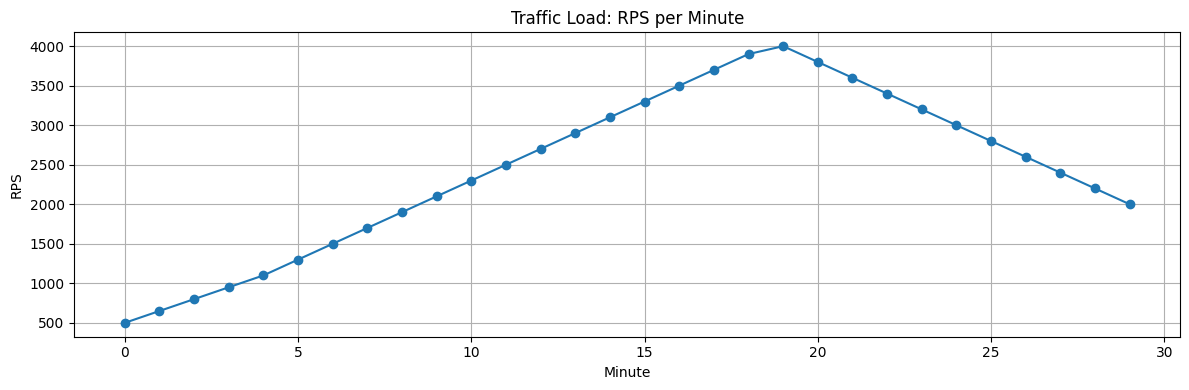

In [18]:
from config import RPS_30MIN_GRADUAL_WIDE

def plot_rps_schedule(rps_schedule, title="Traffic Load: RPS per Minute"):
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(rps_schedule)), rps_schedule, marker='o')
    plt.xlabel("Minute")
    plt.ylabel("RPS")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_rps_schedule(RPS_30MIN_GRADUAL_WIDE)


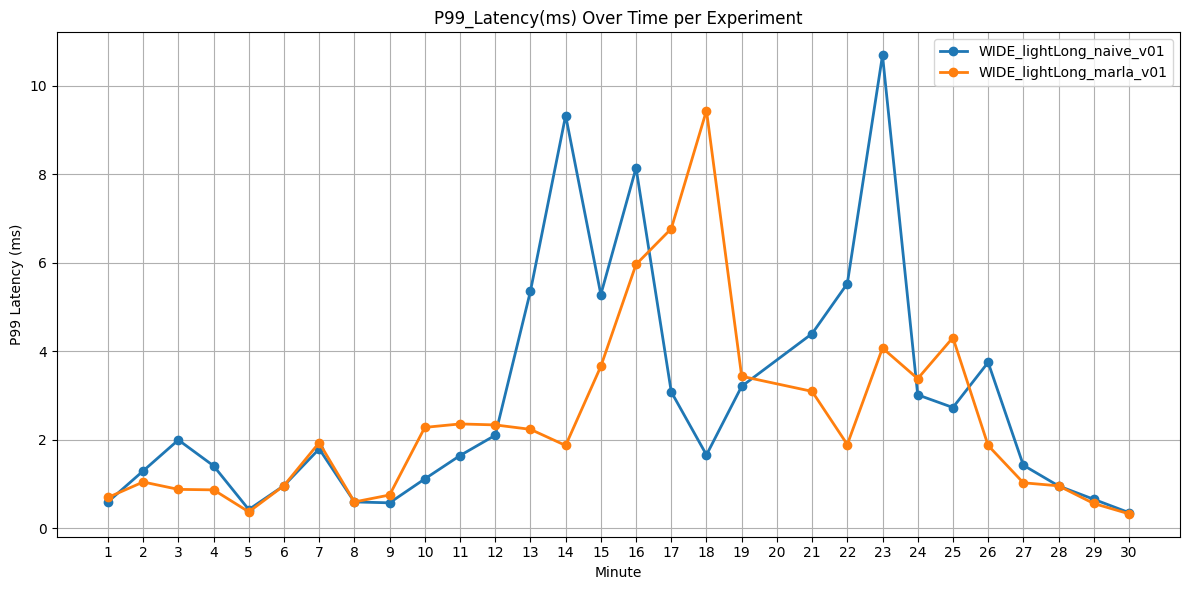

In [19]:
#plot_metric_over_time(["naive_v01.csv", "marla_v01.csv"])
#plot_metric_over_time(["naive_v03.csv", "marla_wide_light_v03.csv"], metric="P99_Latency")
plot_metric_over_time(["WIDE_lightLong_naive_v01.csv","WIDE_lightLong_marla_v01.csv"]) 
